In [1]:
import warnings
warnings.filterwarnings('ignore')

#image segmentation
import cv2
import numpy as np

def getAreaOfFood(img1):
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img_filt = cv2.medianBlur( img, 5)
    img_th = cv2.adaptiveThreshold(img_filt,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # find contours. sort. and find the biggest contour. the biggest contour corresponds to the plate and fruit.
    mask = np.zeros(img.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    img_bigcontour = cv2.bitwise_and(img1,img1,mask = mask)
    
    # convert to hsv. otsu threshold in s to remove plate
    hsv_img = cv2.cvtColor(img_bigcontour, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv_img)
    mask_plate = cv2.inRange(hsv_img, np.array([0,0,50]), np.array([200,90,250]))
    mask_not_plate = cv2.bitwise_not(mask_plate)
    fruit_skin = cv2.bitwise_and(img_bigcontour,img_bigcontour,mask = mask_not_plate)
    
    #convert to hsv to detect and remove skin pixels
    hsv_img = cv2.cvtColor(fruit_skin, cv2.COLOR_BGR2HSV)
    skin = cv2.inRange(hsv_img, np.array([0,10,60]), np.array([10,120,255]))
    not_skin = cv2.bitwise_not(skin)
    fruit = cv2.bitwise_and(fruit_skin,fruit_skin,mask = not_skin)
    
    fruit_bw = cv2.cvtColor(fruit, cv2.COLOR_BGR2GRAY)
    fruit_bin = cv2.inRange(fruit_bw, 10, 255) #binary of fruit
    
    #erode before finding contours
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    erode_fruit = cv2.erode(fruit_bin,kernel,iterations = 1)
    
    #find largest contour since that will be the fruit
    img_th = cv2.adaptiveThreshold(erode_fruit,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_fruit = np.zeros(fruit_bin.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask_fruit, [largest_areas[-2]], 0, (255,255,255), -1)
    
    #dilate now
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
    mask_fruit2 = cv2.dilate(mask_fruit,kernel2,iterations = 1)
    res = cv2.bitwise_and(fruit_bin,fruit_bin,mask = mask_fruit2)
    fruit_final = cv2.bitwise_and(img1,img1,mask = mask_fruit2)
    
    #find area of fruit
    img_th = cv2.adaptiveThreshold(mask_fruit2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    largest_areas = sorted(contours, key=cv2.contourArea)
    fruit_contour = largest_areas[-2]
    fruit_area = cv2.contourArea(fruit_contour)

    #finding the area of skin. find area of biggest contour
    skin2 = skin - mask_fruit2
    
    #erode before finding contours
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    skin_e = cv2.erode(skin2,kernel,iterations = 1)
    img_th = cv2.adaptiveThreshold(skin_e,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_skin = np.zeros(skin.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask_skin, [largest_areas[-2]], 0, (255,255,255), -1)
    
    skin_rect = cv2.minAreaRect(largest_areas[-2])
    box = cv2.boxPoints(skin_rect)
    box = np.int0(box)
    mask_skin2 = np.zeros(skin.shape, np.uint8)
    cv2.drawContours(mask_skin2,[box],0,(255,255,255), -1)
    
    pix_height = max(skin_rect[1])
    pix_to_cm_multiplier = 5.0/pix_height
    skin_area = cv2.contourArea(box)
    
    return fruit_area,fruit_bin ,fruit_final,skin_area, fruit_contour, pix_to_cm_multiplier

In [2]:
# Calorie Calculation
import cv2
import numpy as np


# here we're using density, calorie per 100 gm of the fruit.

#density - gram / cm^3, 
# Apple - 1, Banana - 2, Carrot - 3, Cucumber - 4, Onion - 5, Orange - 6, tomato - 7
density_dict = { 1:0.609, 2:0.94, 3:0.577, 4:0.641, 5:1.151, 6:0.482, 7:0.513, 8:0.641, 9:0.481, 10:0.641, 11:0.521, 12:0.881, 13:0.228, 14:0.650 }

#kcal
calorie_dict = { 1:52, 2:89, 3:92, 4:41, 5:360, 6:47, 7:40, 8:158, 9:18, 10:16, 11:50, 12:61, 13:31, 14:30 }

#skin of photo to real multiplier
skin_multiplier = 5*2.3

def getCalorie(label, volume): #volume in cm^3
    calorie = calorie_dict[int(label)]
    density = density_dict[int(label)]
    mass = volume*density*1.0
    calorie_tot = (calorie/100.0)*mass
    return mass, calorie_tot, calorie #calorie per 100 grams

def getVolume(label, area, skin_area, pix_to_cm_multiplier, fruit_contour):
    area_fruit = (area/skin_area)*skin_multiplier #area in cm^2
    label = int(label)
    volume = 100
    if label == 1 or label == 5 or label == 6 or label == 7 : #sphere - apple, onion, orange, tomato
        radius = np.sqrt(area_fruit/np.pi)
        volume = (4/3)*np.pi*radius*radius*radius
        #print (area_fruit, radius, volume, skin_area)
    
    if label == 2 or label == 4 or label == 3: #cylinder like banana, cucumber, carrot
        fruit_rect = cv2.minAreaRect(fruit_contour)
        height = max(fruit_rect[1])*pix_to_cm_multiplier
        radius = area_fruit/(2.0*height)
        volume = np.pi*radius*radius*height
    
    return volume

def calories(result,img):
    img_path =img 
    fruit_areas,final_f,areaod,skin_areas, fruit_contours, pix_cm = getAreaOfFood(img_path)
    volume = getVolume(result, fruit_areas, skin_areas, pix_cm, fruit_contours)
    mass, cal, cal_100 = getCalorie(result, volume)
    fruit_volumes=volume
    fruit_calories=cal
    fruit_calories_100grams=cal_100
    fruit_mass=mass
    print("\nvolume of fruit(cm^3): ",fruit_volumes,"\ncalories in 100 grams of this fruit(kcal): ",fruit_calories_100grams,"\nmass of fruit(gm): ",fruit_mass,"\ntotal calories in the fruit(kcal): ",fruit_calories)
    return fruit_calories

In [3]:
# Convolution Neural Network for Fruit Classification

import tensorflow as tf

def get_model(IMG_SIZE, no_of_fruits, LR):
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(no_of_fruits, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Apple
Bannana
carrot
cucumber
Onion
Orange
tomato



Epoch 1/10


4/4 [==============================] - 12s 2s/step - loss: 2159.7336 - accuracy: 0.1364 - val_loss: 187.4517 - val_accuracy: 0.1064
Epoch 2/10
4/4 [==============================] - 9s 2s/step - loss: 190.0764 - accuracy: 0.2091 - val_loss: 18.7043 - val_accuracy: 0.2128
Epoch 3/10
4/4 [==============================] - 10s 3s/step - loss: 19.6150 - accuracy: 0.3182 - val_loss: 2.4589 - val_accuracy: 0.4255
Epoch 4/10
4/4 [==============================] - 9s 2s/step - loss: 2.4337 - accuracy: 0.5455 - val_loss: 1.3437 - val_accuracy: 0.4255
Epoch 5/10
4/4 [==============================] - 9s 2s/step - loss: 1.2083 - accuracy: 0.6455 - val_loss: 1.3374 - val_accuracy: 0.4043
Epoch 6/10
4/4 [==============================] - 9s 2s/step - loss: 0.9785 - accuracy: 0.6273 - val_loss: 1.3239 - val_accuracy: 0.4255
Epoch 7/10
4/4 [==============================] - 9s 2s/step - loss: 0.6125 - accuracy: 0.7636 - val_loss: 1.588

INFO:tensorflow:Assets written to: model\Fruits_dectector-0.001-5conv-basic.model\assets


Model Save At model\Fruits_dectector-0.001-5conv-basic.model


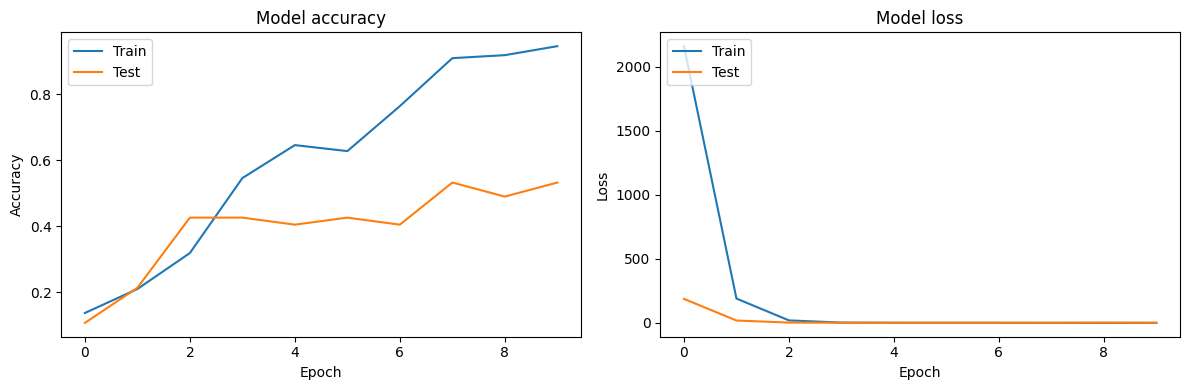

In [4]:
# Training the CNN model

import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
import glob
import cv2

# Get the current working directory where the notebook resides
path = 'images'
IMG_SIZE = 400
LR = 1e-3
MODEL_NAME = 'Fruits_dectector-{}-{}.model'.format(LR, '5conv-basic')
no_of_fruits = 7
percentage = 0.3
no_of_images = 100

def create_train_data(path):
    images = []
    labels = []
    folders = os.listdir(path)[0:no_of_fruits]
    for i in range(len(folders)):
        label = [0 for i in range(no_of_fruits)]
        label[i] = 1
        print(folders[i])
        k = 0
        for j in glob.glob(os.path.join(path, folders[i], '*.jpg')):
            if k == no_of_images:
                break
            k += 1
            img = cv2.imread(j)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(np.array(img))
            labels.append(np.array(label))
    np.save('images_{}_{}_{}.npz'.format(no_of_fruits, no_of_images, IMG_SIZE), images)
    np.save('labels_{}_{}_{}.npz'.format(no_of_fruits, no_of_images, IMG_SIZE), labels)
    training_data = list(zip(images, labels))
    shuffle(training_data)
    return training_data, folders


# Call the create_train_data function with the updated path
training_data, labels = create_train_data(path)

# Split the training data into training and testing sets
size = int(len(training_data) * percentage)
train = training_data[:-size]
test = training_data[-size:]

X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = [i[1] for i in train]
Y = np.array(Y)

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
test_y = [i[1] for i in test]
test_y = np.array(test_y)

model = get_model(IMG_SIZE, no_of_fruits, LR)

# Train the model with the training data
history = model.fit(X, Y, epochs=10, validation_data=(test_x, test_y))
# model.fit(X, Y, epochs=10, validation_data=(test_x, test_y), snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

# Save the trained model
model_save_at=os.path.join("model",MODEL_NAME)
model.save(model_save_at)
print("Model Save At",model_save_at)

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 324ms/step

volume of fruit(cm^3):  175.16941245656318 
calories in 100 grams of this fruit(kcal):  52 
mass of fruit(gm):  106.67817218604698 
total calories in the fruit(kcal):  55.472649536744434


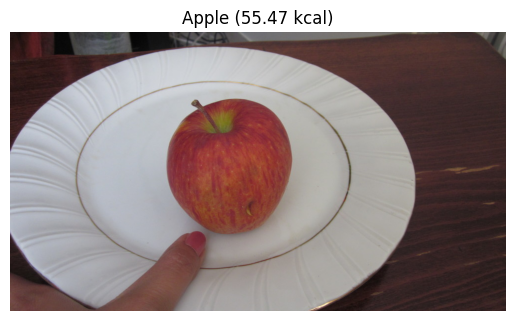

In [5]:
# demo

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

IMG_SIZE = 400
LR = 1e-3
no_of_fruits = 7

MODEL_NAME = 'Fruits_dectector-{}-{}.model'.format(LR, '5conv-basic')
model_path = os.path.join("model", MODEL_NAME)  # Save the model in the "model" directory


# Load the saved model
loaded_model = tf.keras.models.load_model(model_path)

# Load labels

labels = ['Apple', 'Banana', 'Carrot', 'Cucumber', 'Onion', 'Orange', 'Tomato'] 


# Load and preprocess the test image
test_data = '7.jpg'
img = cv2.imread(test_data)
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_processed = np.expand_dims(img_resized, axis=0)

# Make predictions
model_out = loaded_model.predict(img_processed)
result = np.argmax(model_out)
name = labels[result]
cal = round(calories(result + 1, img), 2)

# Display the results
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('{} ({} kcal)'.format(name, cal))
plt.axis('off')
plt.show()